<a href="https://colab.research.google.com/github/NoorFatimaMemon/DeepLearning/blob/main/26_Intro_to_Autoencoders/26_Convolutional_Variational_Autoencoder_in_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Variational Autoencoder**

## **Setup**

In [40]:
!pip install -q tensorflow-probability  # tools for probabilistic modeling.
!pip install -q imageio   # to generate gifs
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [41]:
from IPython import display   # clear notebook output b/w epochs
import tensorflow as tf
import tensorflow_probability as tfp    # probability distributions
import matplotlib.pyplot as plt
import numpy as np
import glob       # file pattern matching
import imageio
import PIL
import time

## **Load the Fashion-MNIST dataset**

In [42]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

In [43]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [44]:
train_size, test_size = 60000, 10000
batch_size = 32

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size))

## **Build CVAE Model**

In [45]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                                            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
                                            tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
                                            tf.keras.layers.Flatten(),tf.keras.layers.Dense(latent_dim + latent_dim),  # mean + logvar
                                            ])
        # Decoder
        self.decoder = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                                            tf.keras.layers.Dense(7*7*32, activation='relu'),
                                            tf.keras.layers.Reshape((7, 7, 32)),
                                            tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
                                            tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
                                            tf.keras.layers.Conv2DTranspose(1, 3, strides=1, padding='same'),])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits

    def sample_from_prior(self, n_samples=16):
        z = tf.random.normal(shape=(n_samples, self.latent_dim))
        return self.decode(z, apply_sigmoid=True)

## **Loss & Train Step**

In [46]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x, kl_weight=1.0):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + kl_weight * (logpz - logqz_x))

@tf.function
def train_step(model, x, optimizer, kl_weight):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, kl_weight)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## **Visualization**

In [47]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    reconstructions = model.decode(z, apply_sigmoid=True)

    fig = plt.figure(figsize=(4, 4))
    for i in range(reconstructions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(reconstructions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

## **Training Loop**


Epoch: 50, Test ELBO: -132.1020, time: 8.49s, KL weight: 1.00


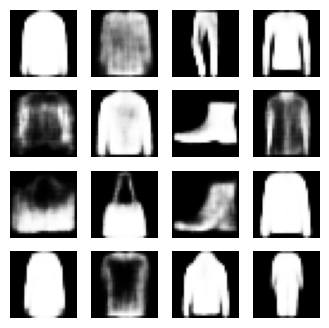

In [48]:
epochs = 50
latent_dim = 10
model = CVAE(latent_dim)

# Pick a test sample for monitoring
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:16, :, :, :]

generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    kl_weight = min(1.0, epoch / 10)  # warm-up over first 10 epochs
    for train_x in train_dataset:
        train_step(model, train_x, optimizer, kl_weight)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x, kl_weight))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print(f'Epoch: {epoch}, Test ELBO: {elbo:.4f}, time: {end_time - start_time:.2f}s, KL weight: {kl_weight:.2f}')
    generate_and_save_images(model, epoch, test_sample)

### **Random Samples from Prior**

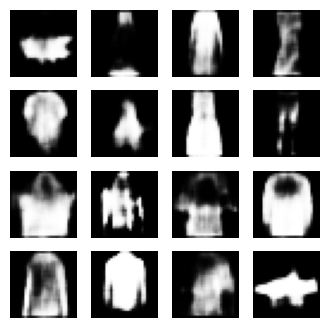

In [49]:
random_images = model.sample_from_prior(16)
fig = plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(random_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()